In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import time

In [2]:
example = pd.read_csv('/kaggle/input/20230726-h/20230726-H/example.csv')
example.sample(3)

,target
43,0
490,0
380,1


In [3]:
train = pd.read_csv('/kaggle/input/20230726-h/20230726-H/train.csv')
train.head()

,A,B,C,D,E,F,G,H,I,target
0,0.505,8,-,1.984,3.0,5,2.642,-5.122,0.649,1
1,0.536,4,-,1.977,1.0,3,5.756,-3.077,0.950,0
2,0.024,3,-,3.147,2.0,6,2.435,4.387,2.186,1
3,0.543,4,-,2.440,3.0,9,4.440,7.730,1.938,0
4,0.942,8,-,1.952,3.0,9,7.176,-4.579,0.346,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   int64  
 2   C       1000 non-null   object 
 3   D       1000 non-null   float64
 4   E       925 non-null    float64
 5   F       1000 non-null   int64  
 6   G       1000 non-null   float64
 7   H       1000 non-null   float64
 8   I       1000 non-null   float64
 9   target  1000 non-null   int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 78.3+ KB


In [5]:
train[train['E'].isna()].target.value_counts(normalize=True)

target
0    0.973333
1    0.026667
Name: proportion, dtype: float64

In [6]:
train.target.value_counts(normalize=True)

target
0    0.712
1    0.288
Name: proportion, dtype: float64

In [7]:
test = pd.read_csv('/kaggle/input/20230726-h/20230726-H/test.csv')
test.head()

,A,B,C,D,E,F,G,H,I
0,0.489,4,+,1.722,3.0,2,5.727,3.126,1.858
1,0.479,8,-,2.282,3.0,8,4.955,2.650,2.769
2,0.640,2,+,1.918,2.0,2,5.971,1.216,2.062
3,0.649,6,-,1.696,2.0,2,4.946,-0.480,1.133
4,0.272,1,-,1.721,1.0,7,4.670,8.785,5.090


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       500 non-null    float64
 1   B       500 non-null    int64  
 2   C       500 non-null    object 
 3   D       500 non-null    float64
 4   E       457 non-null    float64
 5   F       500 non-null    int64  
 6   G       500 non-null    float64
 7   H       500 non-null    float64
 8   I       500 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 35.3+ KB


In [9]:
test.B.value_counts()

B
3     89
5     88
4     78
6     78
2     63
7     32
8     28
1     26
9      7
0      5
10     3
11     2
12     1
Name: count, dtype: int64

In [10]:
train.nunique()

A         638
B          15
C           2
D         604
E           3
F          10
G         905
H         960
I         833
target      2
dtype: int64

In [11]:
train.nunique()

A         638
B          15
C           2
D         604
E           3
F          10
G         905
H         960
I         833
target      2
dtype: int64

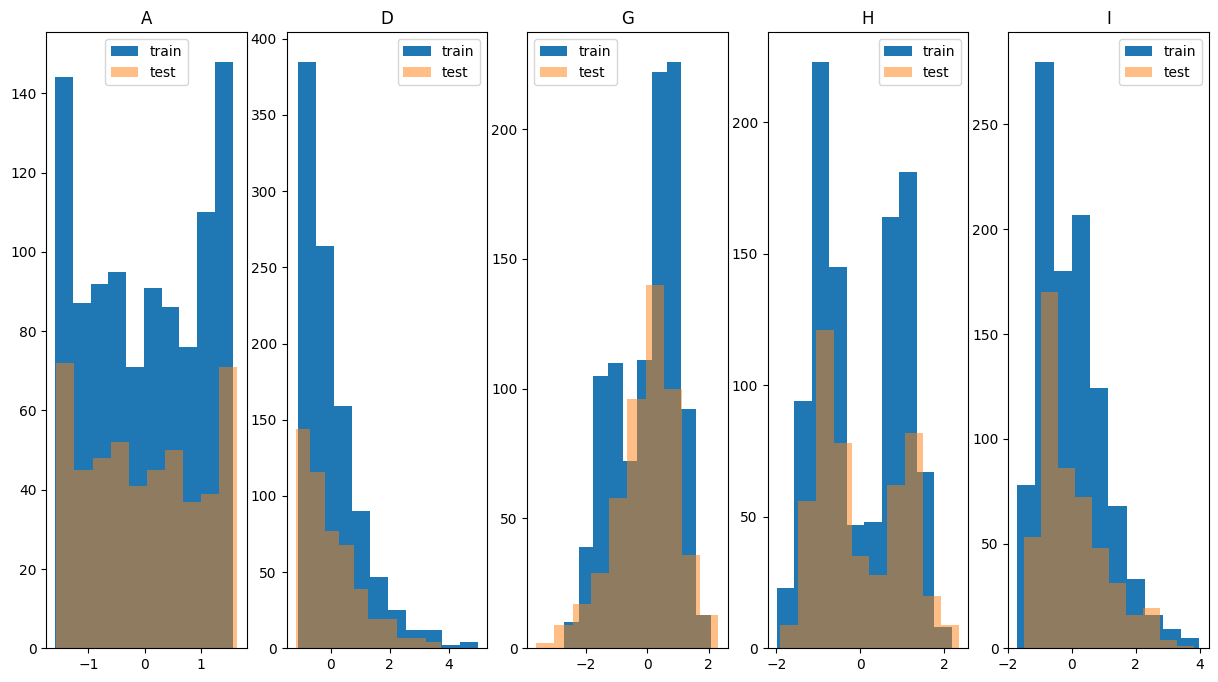

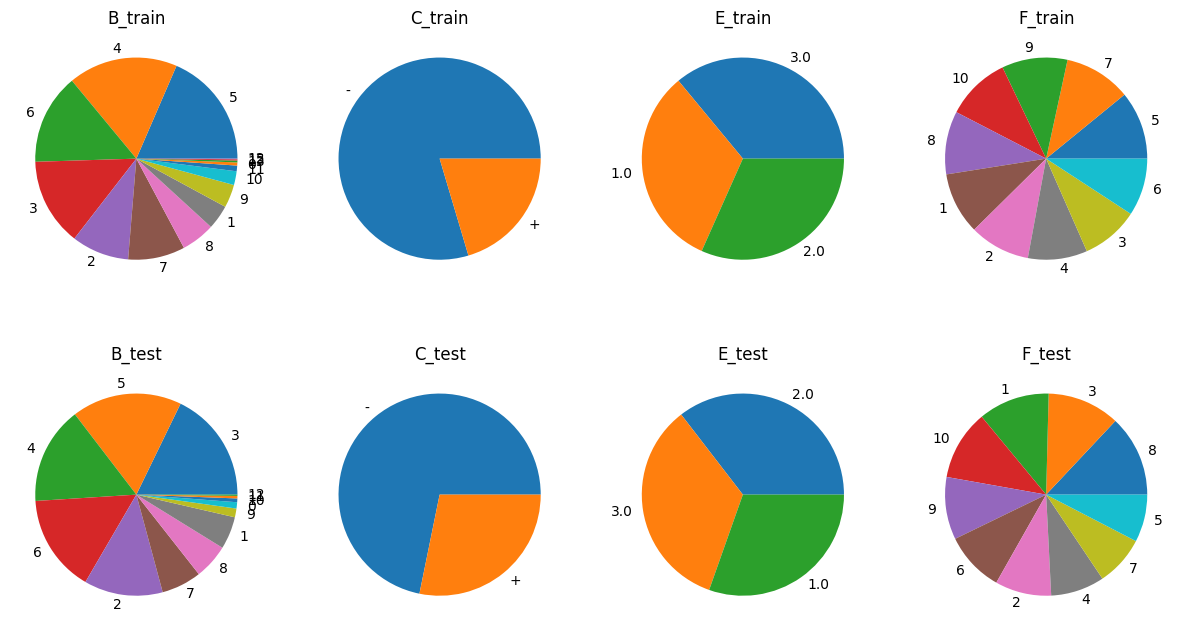

In [12]:
num_cols = ['A', 'D', 'G', 'H', 'I']
target = ['target']
cat_cols = ['B', 'C', 'E', 'F']

fig = plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot(1, 5, i + 1)
    plt.hist((train[col] - train[col].mean())/train[col].std(), label='train')
    plt.hist((test[col] - test[col].mean())/test[col].std(), alpha=0.5, label='test')
    plt.title(col)
    plt.legend()
plt.show()

fig = plt.figure(figsize=(15, 8))
for i, col in enumerate(cat_cols):
    
    plt.subplot(2, 4, i + 1)
    counts = train[col].value_counts(normalize=True)
    plt.pie(counts, labels=counts.index)
    plt.title(f'{col}_train')
    
    plt.subplot(2, 4, 4 + i + 1)
    counts = test[col].value_counts(normalize=True)
    plt.pie(counts, labels=counts.index)
    plt.title(f'{col}_test')
plt.show()

In [13]:
log_train = np.log(11 + train[num_cols])
log_train.sample(3)

,A,D,G,H,I
1,2.445473,2.563179,2.818756,2.069770,2.480731
591,2.436154,2.548351,2.809885,2.806023,2.536550
637,2.435016,2.583167,2.825715,2.644897,2.574138


In [14]:
log_test = np.log(11 + test[num_cols])
log_test.sample(3)

,A,D,G,H,I
397,2.435979,2.587914,2.804148,2.888425,2.676972
470,2.447118,2.612640,2.795817,2.896188,2.661797
9,2.411798,2.545139,2.764494,2.475109,2.626117


In [15]:
train[['E', 'target']].value_counts(normalize=True)

E    target
1.0  0         0.292973
2.0  0         0.231351
3.0  1         0.193514
     0         0.166486
2.0  1         0.085405
1.0  1         0.030270
Name: proportion, dtype: float64

In [16]:
len(train.drop(columns='target').columns)

9

In [17]:
train[cat_cols]

,B,C,E,F
0,8,-,3.0,5
1,4,-,1.0,3
2,3,-,2.0,6
3,4,-,3.0,9
4,8,-,3.0,9
...,...,...,...,...
995,3,-,1.0,8
996,5,-,1.0,3
997,11,-,1.0,3
998,7,-,1.0,8


In [18]:
train[train['E'] == 1.0]['B'].value_counts(normalize=True)

B
5     0.204013
3     0.163880
4     0.150502
6     0.130435
2     0.093645
7     0.083612
8     0.053512
9     0.040134
1     0.036789
10    0.016722
11    0.016722
13    0.006689
0     0.003344
Name: proportion, dtype: float64

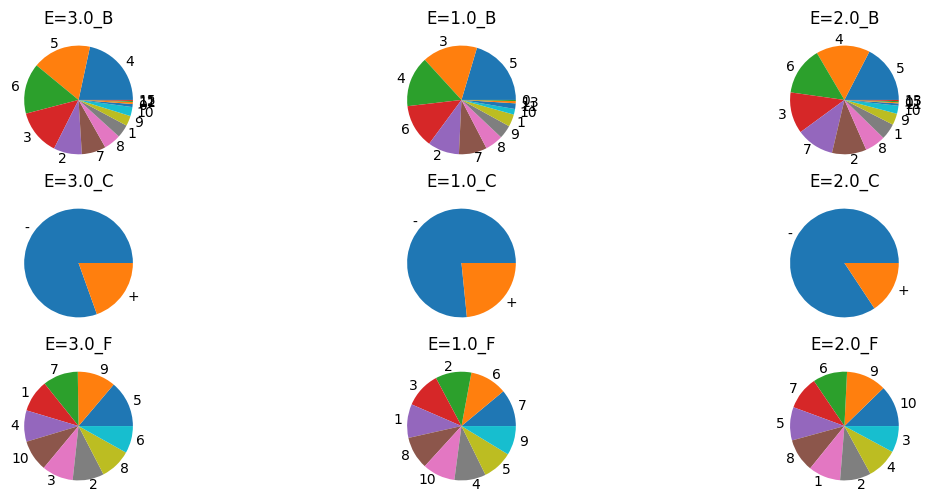

In [19]:
values = train['E'].value_counts().index
plt.figure(figsize=(14, 6))
i = 1
for col in train[cat_cols].drop(columns=['E']).columns:
    for val in values:
        plt.subplot(3, 3, i)
        counts = train[train['E'] == val][col].value_counts(normalize=True)
        plt.pie(counts, labels=counts.index)
        plt.title(f'E={val}_{col}')

        i += 1
        
    
    

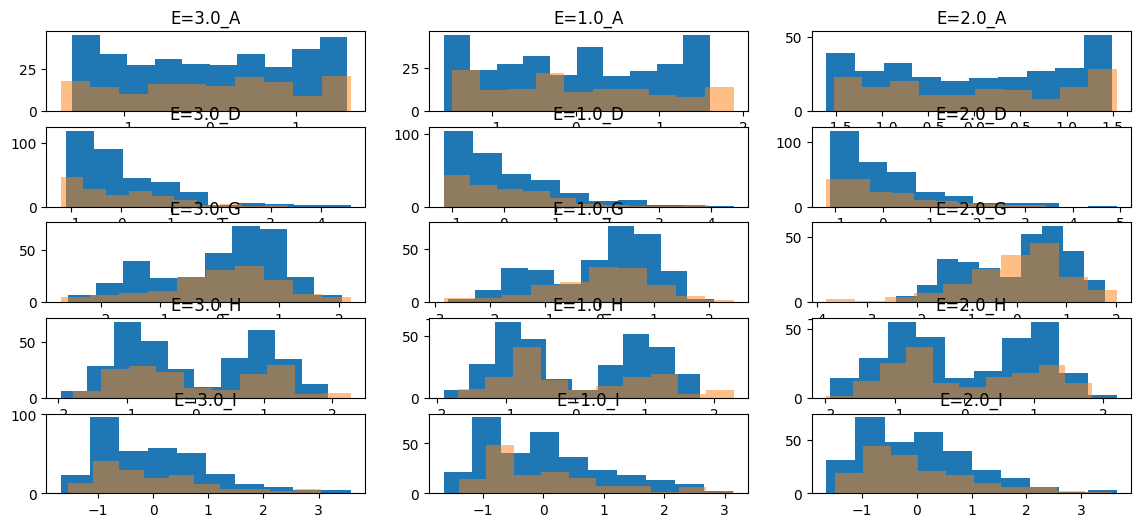

In [20]:
values = train['E'].value_counts().index
plt.figure(figsize=(14, 6))
i = 1
for col in num_cols:
    for val in values:
        plt.subplot(5, 3, i)
        
        plt.hist((train[train['E']==val][col] - train[train['E']==val][col].mean())/train[train['E']==val][col].std(), label='train')
        plt.hist((test[test['E']==val][col] - test[test['E'] == val][col].mean())/test[test['E'] == val][col].std(), alpha=0.5, label='test')
        
        plt.title(f'E={val}_{col}')

        i += 1

In [21]:
X, y = train.drop(columns='target').fillna(''), train['target']
X['C'] = X['C'].astype(str)
X['E'] = X['E'].astype(str)

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   int64  
 2   C       1000 non-null   object 
 3   D       1000 non-null   float64
 4   E       1000 non-null   object 
 5   F       1000 non-null   int64  
 6   G       1000 non-null   float64
 7   H       1000 non-null   float64
 8   I       1000 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 70.4+ KB


In [23]:
%%time
import torch
grid = {
    'iterations': [500, 550], #5], #470, 500, 530],
    'learning_rate': [0.03, 0.05], #0.03, 0.035],# 0.255, 0.03, 0.33, 0.0335, 0.035],#[None, 0.03, 0.05, 0.1, 0.5],
    'depth': [3, 4, 5, 6, 7]#3, 4]#[None, 4, 5, 6]
}
task_type = 'GPU' if torch.cuda.is_available() else 'CPU'
model = CatBoostClassifier(
    task_type=task_type,
    cat_features=cat_cols,
    # random_state=17,
    logging_level='Silent',
    eval_metric='AUC'
)

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True,
                              # random_state=17
                             )
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid,
    cv=cv_strategy,
    scoring='roc_auc',
    verbose=1)
grid_search.fit(X, y)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

CPU times: user 20min 10s, sys: 2min, total: 22min 11s
Wall time: 18min 7s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x78dda87b09d0>,
             param_grid={'depth': [3, 4, 5, 6, 7], 'iterations': [500, 550],
                         'learning_rate': [0.03, 0.05]},
             scoring='roc_auc', verbose=1)

In [24]:
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший AUC на кросс-валидации: {grid_search.best_score_:.4f}")
best_model = grid_search.best_estimator_

Лучшие параметры: {'depth': 3, 'iterations': 500, 'learning_rate': 0.05}
Лучший AUC на кросс-валидации: 0.8720


In [25]:
model_name = '_'.join([f'{grid_search.best_score_:.4f}_AUC'] + [ f'{n}_{p}' for n, p in grid_search.best_params_.items()])
model_name

'0.8720_AUC_depth_3_iterations_500_learning_rate_0.05'

In [ ]:
test['E'] = test['E'].fillna('').astype('str')
test['target'] = best_model.predict_proba(test)
test.to_csv(f'{model_name}.csv', index=False)
test

In [33]:
test['target_proba'] = best_model.predict_proba(test)[:, 1]  # <-- Извлекаем вероятности класса 1
test.to_csv(f'{model_name}.csv', index=False)
test

,A,B,C,D,E,F,G,H,I,target,target_proba
0,0.489,4,+,1.722,3.0,2,5.727,3.126,1.858,0,0.114849
1,0.479,8,-,2.282,3.0,8,4.955,2.650,2.769,0,0.089222
2,0.640,2,+,1.918,2.0,2,5.971,1.216,2.062,0,0.115848
3,0.649,6,-,1.696,2.0,2,4.946,-0.480,1.133,0,0.052025
4,0.272,1,-,1.721,1.0,7,4.670,8.785,5.090,0,0.030795
...,...,...,...,...,...,...,...,...,...,...,...
495,0.273,1,-,2.006,,10,4.722,8.541,5.063,0,0.011910
496,0.996,3,-,1.743,1.0,1,5.415,-10.913,-0.169,0,0.030945
497,0.550,5,-,1.770,3.0,3,3.998,5.320,2.054,0,0.016515
498,0.966,2,+,1.984,1.0,6,5.999,-5.422,0.534,0,0.046129


In [34]:
test[test['E'] == ''].target.value_counts()

target
0    43
Name: count, dtype: int64

In [28]:
pd.read_csv(f'{model_name}.csv')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,A,B,C,D,E,F,G,H,I,target
0,0.489,4,+,1.722,3.0,2,5.727,3.126,1.858,0
1,0.479,8,-,2.282,3.0,8,4.955,2.650,2.769,0
2,0.640,2,+,1.918,2.0,2,5.971,1.216,2.062,0
3,0.649,6,-,1.696,2.0,2,4.946,-0.480,1.133,0
4,0.272,1,-,1.721,1.0,7,4.670,8.785,5.090,0
...,...,...,...,...,...,...,...,...,...,...
495,0.273,1,-,2.006,NaN,10,4.722,8.541,5.063,0
496,0.996,3,-,1.743,1.0,1,5.415,-10.913,-0.169,0
497,0.550,5,-,1.770,3.0,3,3.998,5.320,2.054,0
498,0.966,2,+,1.984,1.0,6,5.999,-5.422,0.534,0


In [35]:
submission = test[['target_proba']]
submission.to_csv(f'{model_name}_submission.csv', index=False)
submission

,target_proba
0,0.114849
1,0.089222
2,0.115848
3,0.052025
4,0.030795
...,...
495,0.011910
496,0.030945
497,0.016515
498,0.046129


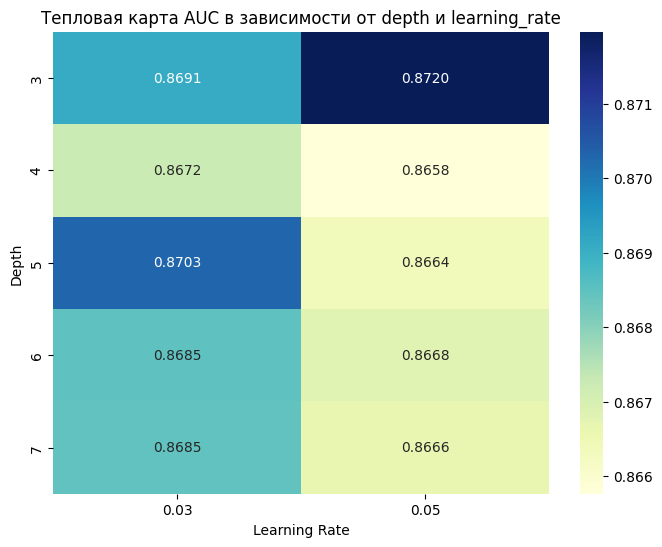

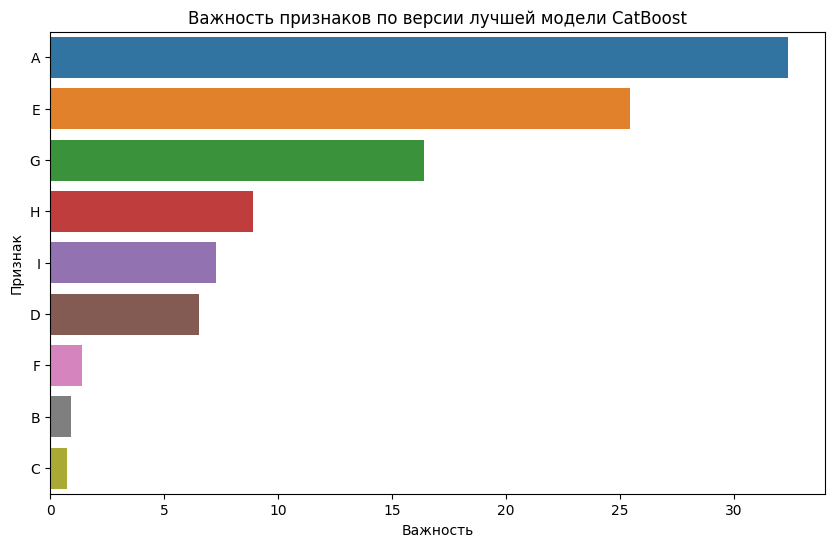

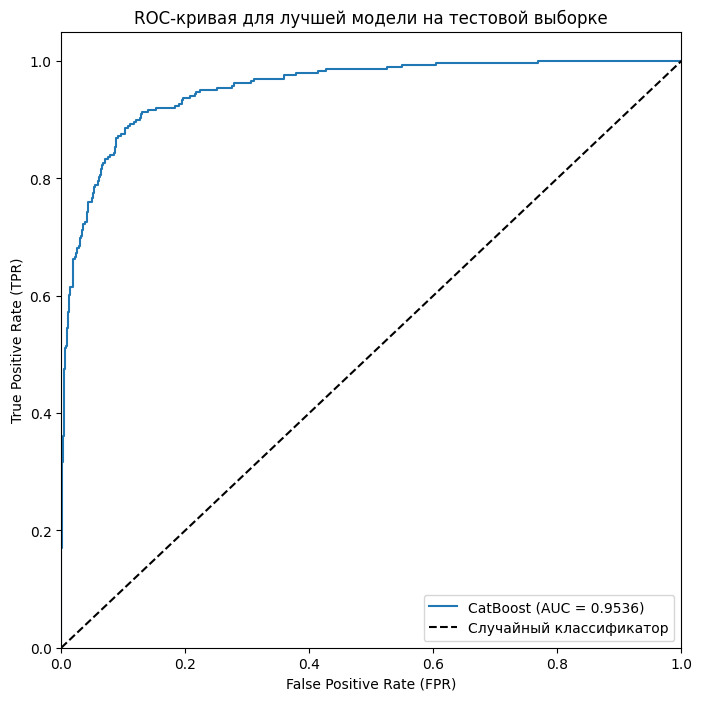

In [30]:
results_df = pd.DataFrame(grid_search.cv_results_)
pivot = results_df.pivot_table(
    values='mean_test_score',
    index='param_depth',
    columns='param_learning_rate'
)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Тепловая карта AUC в зависимости от depth и learning_rate')
plt.xlabel('Learning Rate')
plt.ylabel('Depth')
plt.show()

# 6.2. График важности признаков
feature_importances = pd.Series(
    best_model.get_feature_importance(),
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Важность признаков по версии лучшей модели CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

# 6.3. ROC-кривая на тестовой выборке
y_pred_proba = best_model.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
auc_test = roc_auc_score(y, y_pred_proba)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для лучшей модели на тестовой выборке')
plt.legend(loc="lower right")
plt.show()

# Testing

In [31]:
from sklearn.model_selection import train_test_split

AVG_AUC = 0.
for _ in range(15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True)
    model = CatBoostClassifier(**grid_search.best_params_, task_type=task_type, cat_features=cat_cols, logging_level='Silent').fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_test = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC: {auc_test:.4f}')
    AVG_AUC += auc_test
AVG_AUC /= 15
print(f'AVG_AUC: {AVG_AUC:.4f}')


AUC: 0.8707
AUC: 0.8584
AUC: 0.8702
AUC: 0.8895
AUC: 0.8725
AUC: 0.8794
AUC: 0.8666
AUC: 0.8740
AUC: 0.8987
AUC: 0.8950
AUC: 0.9111
AUC: 0.9189
AUC: 0.8679
AUC: 0.8611
AUC: 0.8870
AVG_AUC: 0.8814
